# Salary and link prediction for employees (NetworkX)
---
In this notebook, we are given a company's email network under `email_prediction.txt` where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.



In [14]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib notebook

In [3]:
G = nx.read_gpickle('email_prediction.txt', )

print(nx.info(G))


Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


In [4]:
G.nodes(data=True)[:10]

[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (2, {'Department': 21, 'ManagementSalary': nan}),
 (3, {'Department': 21, 'ManagementSalary': 1.0}),
 (4, {'Department': 21, 'ManagementSalary': 1.0}),
 (5, {'Department': 25, 'ManagementSalary': nan}),
 (6, {'Department': 25, 'ManagementSalary': 1.0}),
 (7, {'Department': 14, 'ManagementSalary': 0.0}),
 (8, {'Department': 14, 'ManagementSalary': nan}),
 (9, {'Department': 14, 'ManagementSalary': 0.0})]

## Salary Prediction

Using network `G`, we will identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, I will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.

Firstly, we are going to put our network into a DataFrame to allow training processes.

In [5]:
# our df's index will be the nodes (employees)
df = pd.DataFrame(index=G.nodes())

# And the two first features are employee's department and a binary variable 
# equal to 1 if an employee has got a Managemement Salary and 0 otherwise.

df['Department'] = pd.Series(nx.get_node_attributes(G, 'Department'))
df['ManagementSalary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
df.head()

,Department,ManagementSalary
0,1,0.0
1,1,NaN
2,21,NaN
3,21,1.0
4,21,1.0


The next step is to think about informative features to add.

Centrality measures of nodes are always good features to differentiate these nodes in efficient way. In particular here because it makes sense that an employee with a management Salary might surely be an important employee.

Therefore, I will compute for each node its:

- **`degree centrality`** : which will make the assumption that important employees are those who have sent/received many emails.

- **`closeness cenrality`** : important employees are those who can easily communicate with a lot of employees.

- **`betweeness centrality`** : important employees are those who are between information flows (make the link between employees) from the bottom to the top of the company's hierarchy.

- **`pagerank`** : important employees are those who have received many emails from important employees.

- **`clustering coefficient`** : if people that are connected with a particular employee are also connected.
    

We will plot feature importance later to see to assess the relevance of these features.

In [6]:
df['Clust_coef'] = pd.Series(nx.clustering(G))
df['Deg_centr'] = pd.Series(nx.degree_centrality(G))
df['Clos_centr'] = pd.Series(nx.closeness_centrality(G))
df['Betw_centr'] = pd.Series(nx.betweenness_centrality(G))
df['PageR'] = pd.Series(nx.pagerank(G))
df.head()

,Department,ManagementSalary,Clust_coef,Deg_centr,Clos_centr,Betw_centr,PageR
0,1,0.0,0.276423,0.043825,0.421991,0.001124,0.001224
1,1,NaN,0.265306,0.051793,0.422360,0.001195,0.001426
2,21,NaN,0.297803,0.094622,0.461490,0.006570,0.002605
3,21,1.0,0.384910,0.070717,0.441663,0.001654,0.001833
4,21,1.0,0.318691,0.095618,0.462152,0.005547,0.002526


We can now separate rows with `ManagementSalary` value from rows that do not have it.

In [8]:
to_predict = df[df['ManagementSalary'].isnull()].drop('ManagementSalary', axis=1)
df.dropna(subset=['ManagementSalary'], inplace=True)

# Separating features from the target
X = df.drop('ManagementSalary', axis=1)
y = df['ManagementSalary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


### Feature Selection

Let's display a pairplot of our features

<IPython.core.display.Javascript object>


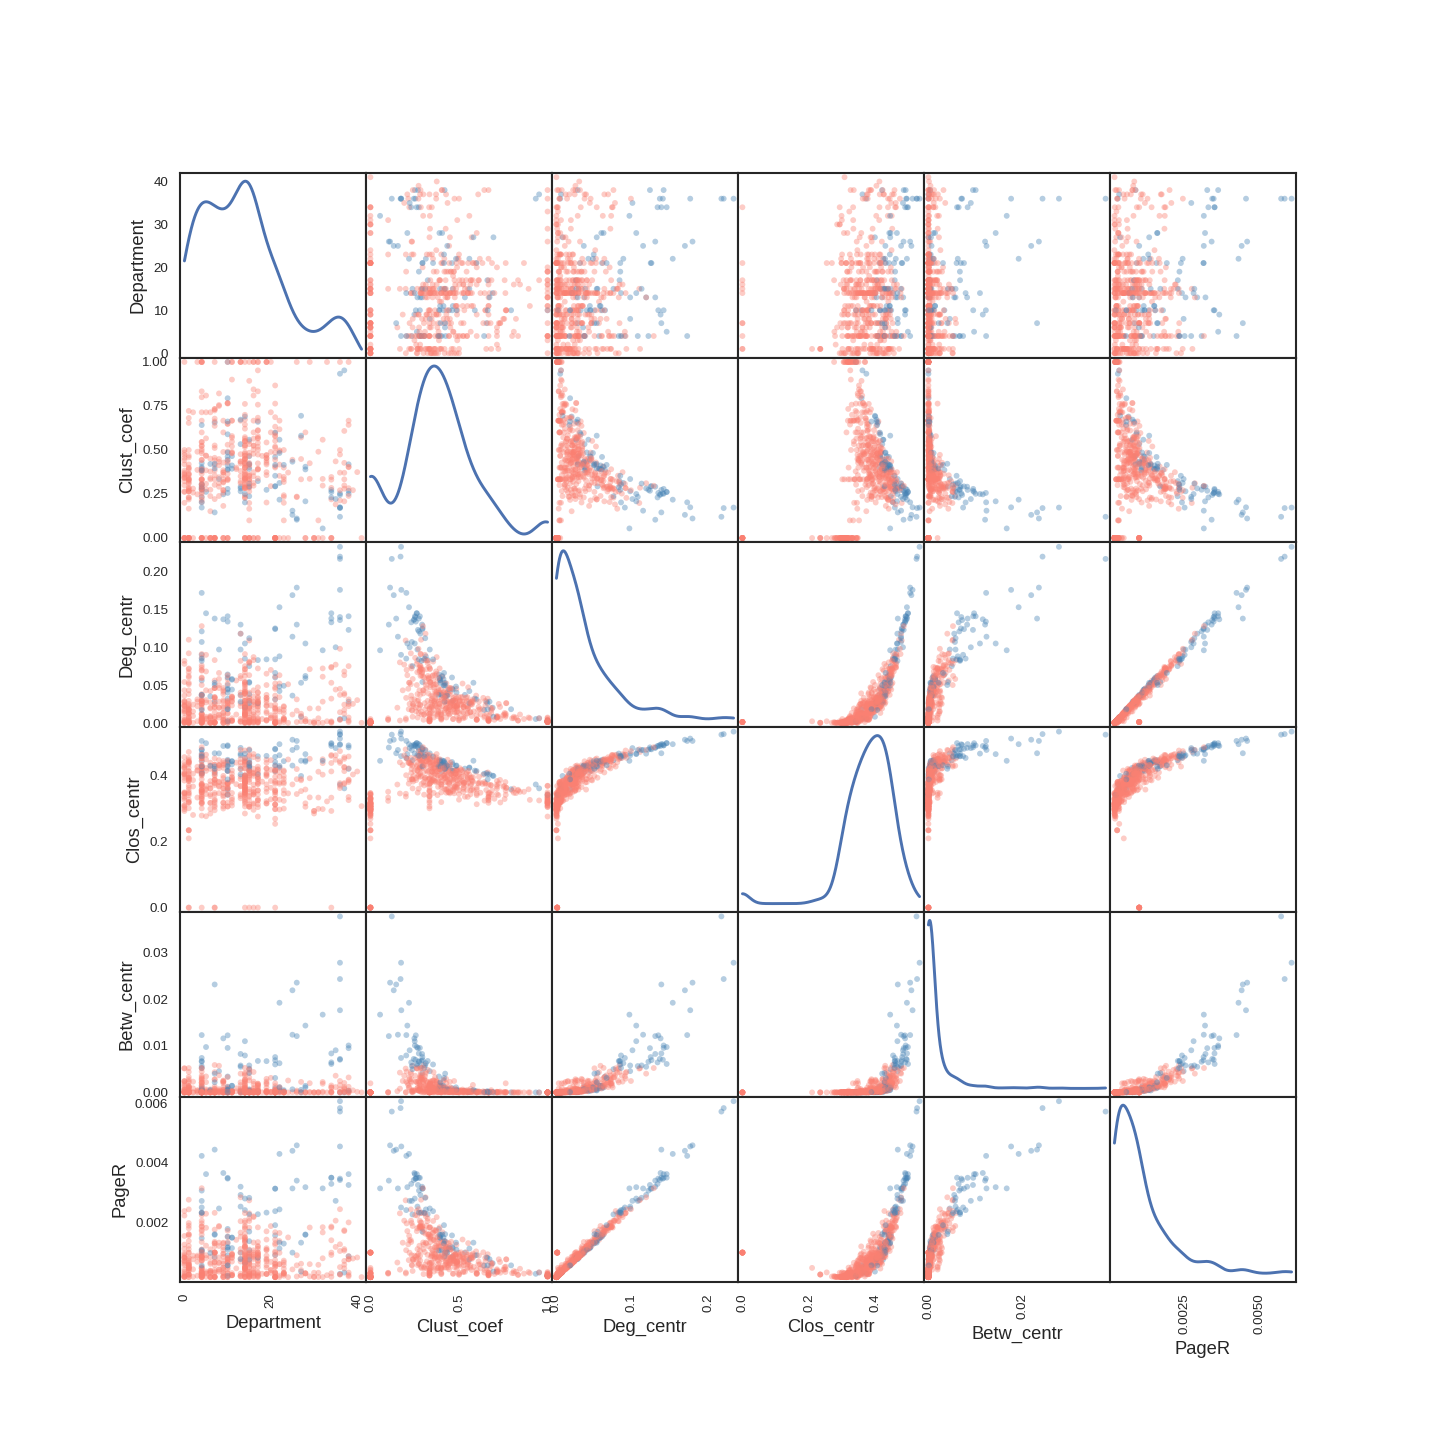

In [9]:
sns.set_style('white')
pd.plotting.scatter_matrix(X_train, alpha=0.4, diagonal = 'kde', c=np.where(y_train==1, 'steelblue', 'salmon'), figsize=(12,12));

Features seems to be very correlated. We should drop some.

The feature that separates classes the best seems to be the **betweeness centrality**. And it makes sense as managers are generally not at the extremeties of the hierarchy. They are somewhat in the middle.

Closeness centrality performs well too.
Let's visualize the correlation matrix of features:

<IPython.core.display.Javascript object>


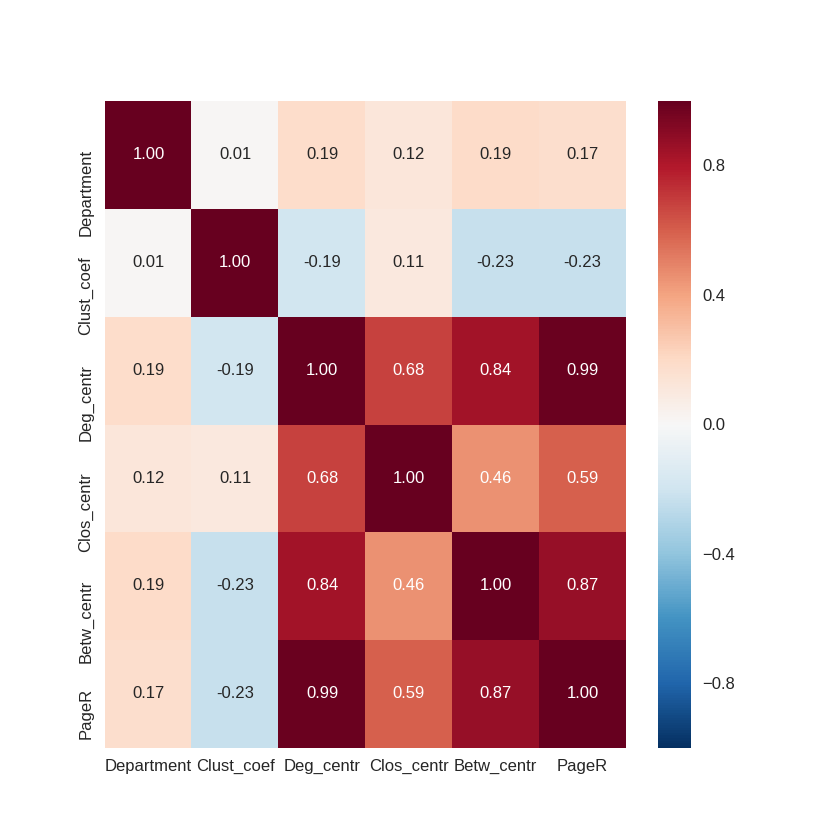

In [10]:
plt.figure(figsize=(7, 7))
sns.heatmap(X_train.corr(), annot=True, fmt='.2f');

To get better predicitions we should certainly choose between `Degree centrality`, `PageRank` and `Betweeness Centrality`.

#### Feature importance with a Decision Tree

<IPython.core.display.Javascript object>


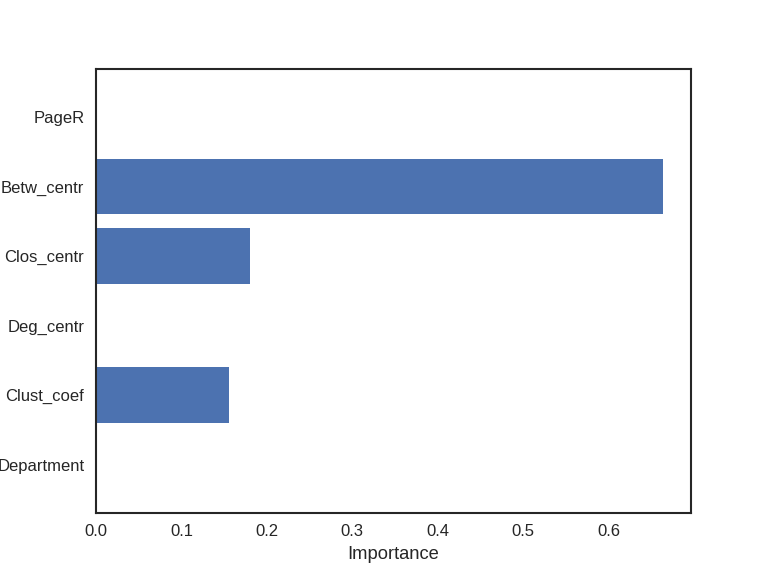

Training score:  0.957942046127
Test score:  0.95607966457


In [11]:
clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=40).fit(X_train, y_train)

plt.figure()
plt.barh(np.arange(len(X.columns)), clf.feature_importances_)
plt.ylabel('Features')
plt.yticks(np.arange(len(X.columns)))
plt.gca().set_yticklabels(list(X.columns))
plt.xlabel('Importance')

print('Training score: ', roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print('Test score: ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))


It totally confirms what we said before, columns to keep are `Betweeness Centrality`, `Closeness Centrality` and `Clustering coefficient`.

In [12]:
X = df.drop(['Deg_centr', 'PageR', 'Department', 'ManagementSalary'], axis=1)
y = df['ManagementSalary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Model Selection

To determine the type of estimator (linear or non linear) to train, a first step might be to extract 2_dimensions features from the data and visualize it.

<IPython.core.display.Javascript object>


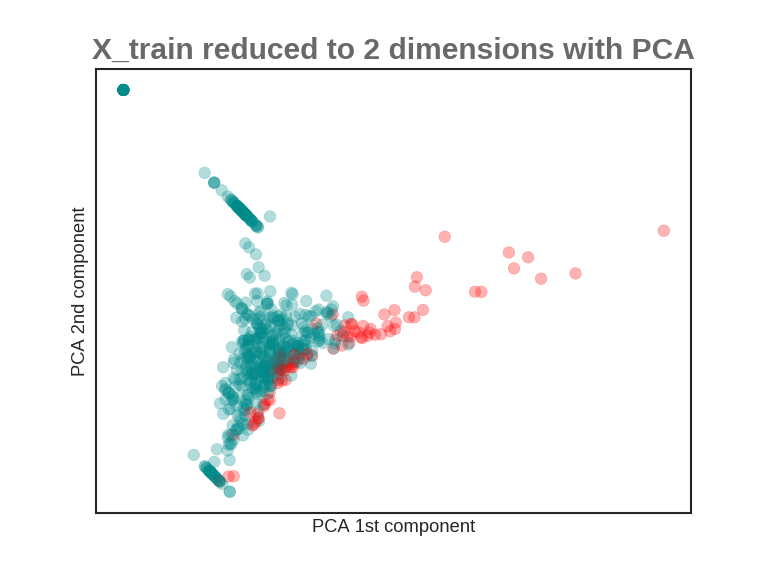

In [15]:
X_normalized = StandardScaler().fit(X_train).transform(X_train)
pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train.map({0: 'darkcyan', 1: 'red'}), alpha=0.3)

plt.title('X_train reduced to 2 dimensions with PCA', fontsize=18, color='dimgrey', fontweight='bold')
plt.tick_params(labelbottom=False, labelleft=False)
plt.xlabel('PCA 1st component')
plt.ylabel('PCA 2nd component');

Data looks linearly separable. Linear svm and logistic regression should work well.

In [16]:
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# clf = SVC(kernel='linear')

# grid_values = {'C': [0.001, 0.001, 0.01, 0.1, 1, 5, 10, 20]}

# grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring='roc_auc', cv=2)

# grid_clf_auc.fit(X_train_scaled, y_train)

# y_decision_fn_train_scores_auc = grid_clf_auc.decision_function(X_train_scaled)
# y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test_scaled)

# print('Grid best parameter (max. auc): ', grid_clf_auc.best_params_)
# print('Grid best score (auc): ', grid_clf_auc.best_score_)
# print('Training score: ', roc_auc_score(y_train, y_decision_fn_train_scores_auc))
# print('Test set auc score', roc_auc_score(y_test, y_decision_fn_scores_auc))


Grid best parameter (max. auc):  {'C': 20}
Grid best score (auc):  0.920174669448
Training score:  0.928113542283
Test set auc score 0.920754716981


In [14]:
clf = SVC(kernel='linear', C=0.1).fit(X_train_scaled, y_train)

print('Training score: ', roc_auc_score(y_train, clf.decision_function(X_train_scaled)))
print('Test score: ', roc_auc_score(y_test, clf.decision_function(X_test_scaled)))

Training score:  0.899396806623
Test score:  0.933333333333


In [22]:
clf = LogisticRegression(C=10).fit(X_train_scaled, y_train)

print('Training score: ', roc_auc_score(y_train, clf.decision_function(X_train_scaled)))
print('Test score: ', roc_auc_score(y_test, clf.decision_function(X_test_scaled)))

Training score:  0.921584861029
Test score:  0.926205450734


Good scores. Let's use the Logistic regression model to predict ManagementSalary values of nodes we put aside.

In [34]:
np.mean((clf.predict(to_predict.drop(['Deg_centr', 'PageR', 'Department'], axis=1))))

0.0

Our model predict that none of our remaining employees actually have a management salary!

In [16]:
# from sklearn.model_selection import GridSearchCV

# clf = LogisticRegression()

# grid_values = {'C': [0.001, 0.01, 0.1, 1, 5, 10, 30, 50, 75, 100]}

# grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring='roc_auc', cv=5)

# grid_clf_auc.fit(X_train_scaled, y_train)

# y_decision_fn_scores_auc = grid_clf_auc.predict_proba(X_test_scaled)[:,1]
# y_decision_fn_train_scores_auc = grid_clf_auc.predict_proba(X_train_scaled)[:,1]

# print('Grid best parameter (max. auc): ', grid_clf_auc.best_params_)
# print('Grid best score (auc): ', grid_clf_auc.best_score_)

# print('Train set auc score', roc_auc_score(y_train, y_decision_fn_train_scores_auc))
# print('Test set auc score', roc_auc_score(y_test, y_decision_fn_scores_auc))

Grid best parameter (max. auc):  {'C': 100}
Grid best score (auc):  0.934111230656
Train set auc score 0.937930218805
Test set auc score 0.912578616352


## New Connections Prediction

Now I will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [23]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, I will identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, I will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.

Let's put our non-existent edges to a DataFrame

In [24]:
df = pd.DataFrame(index = nx.non_edges(G))
df.head()

""
"(0, 2)"
"(0, 3)"
"(0, 4)"
"(0, 7)"
"(0, 8)"


For this link prediction task, I will add the following features to the dataset:

- `Jaccard coefficient`: will yield a high value to possible connections between two employees that have a high ratio of common linked employees (other employees with a connection with both of them) among their individual neighbors.
- `Resource Allocation Index`: penalizes pair of employees that have common linked employees that themselves have a lot of linked employees.
- `Preferential Attachment`: will yield a high value to possible connections between two employees that indidually have a lot of connections.

Adding community based features might be a very good idea because each of our nodes belongs to a department. So we will also add `Community Common Neigbors` and `Community resource allocation index`:

In [25]:
df['Jacc_coef'] = [i[2] for i in sorted(nx.jaccard_coefficient(G))]
df['Res_alloc'] = [i[2] for i in sorted(nx.resource_allocation_index(G))]
df['Pref_Attach'] = [i[2] for i in sorted(nx.preferential_attachment(G))]
df['Community_cn'] = [i[2] for i in sorted(nx.cn_soundarajan_hopcroft(G, community='Department'))]
df['Community_ra'] = [i[2] for i in sorted(nx.ra_index_soundarajan_hopcroft(G, community='Department'))]

df.head()

,Jacc_coef,Res_alloc,Pref_Attach,Community_cn,Community_ra
"(0, 2)",0.045802,0.055340,4180,6,0.0
"(0, 3)",0.027273,0.021388,3124,3,0.0
"(0, 4)",0.022222,0.021388,4224,3,0.0
"(0, 7)",0.036364,0.061668,3168,4,0.0
"(0, 8)",0.012821,0.011628,1628,1,0.0


Now we can add our future connections data which will be our label column

In [26]:
df = pd.concat([df, future_connections.sort_index()], axis=1)

# Let's remove the rows with a missing future connection value
to_predict = df[df['Future Connection'].isnull()].drop('Future Connection', axis=1)
df.dropna(subset=['Future Connection'], inplace=True)

In [27]:
X = df.drop('Future Connection', axis=1)
y = df['Future Connection']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Feature selection

<IPython.core.display.Javascript object>


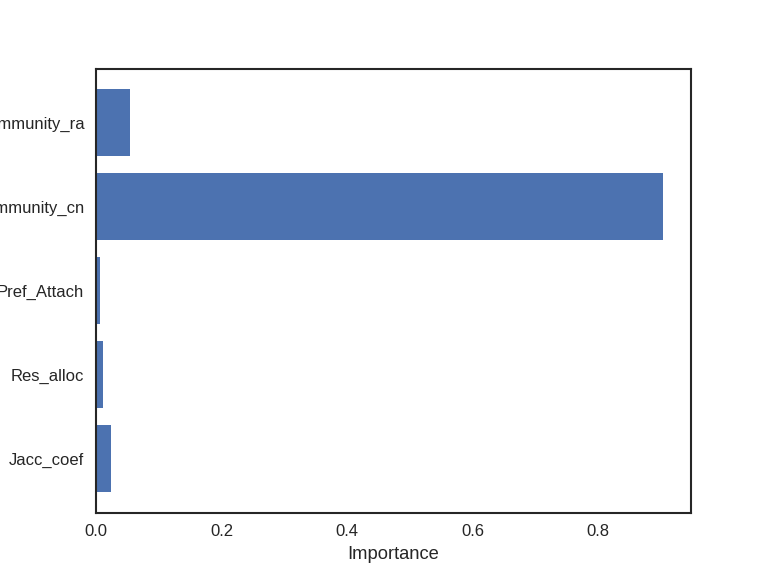

Training score:  0.917763113907
Test score:  0.90480744742


In [28]:
clf = DecisionTreeClassifier(max_depth=9).fit(X_train, y_train)

plt.figure()
plt.barh(np.arange(len(X.columns)), clf.feature_importances_)
plt.ylabel('Features')
plt.yticks(np.arange(len(X.columns)))
plt.gca().set_yticklabels(list(X.columns))
plt.xlabel('Importance')

print('Training score: ', roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print('Test score: ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

It was right to assume that community based features would be very informative! If two employees has many connections in common within the same department they will likely be connected in the future.

<IPython.core.display.Javascript object>


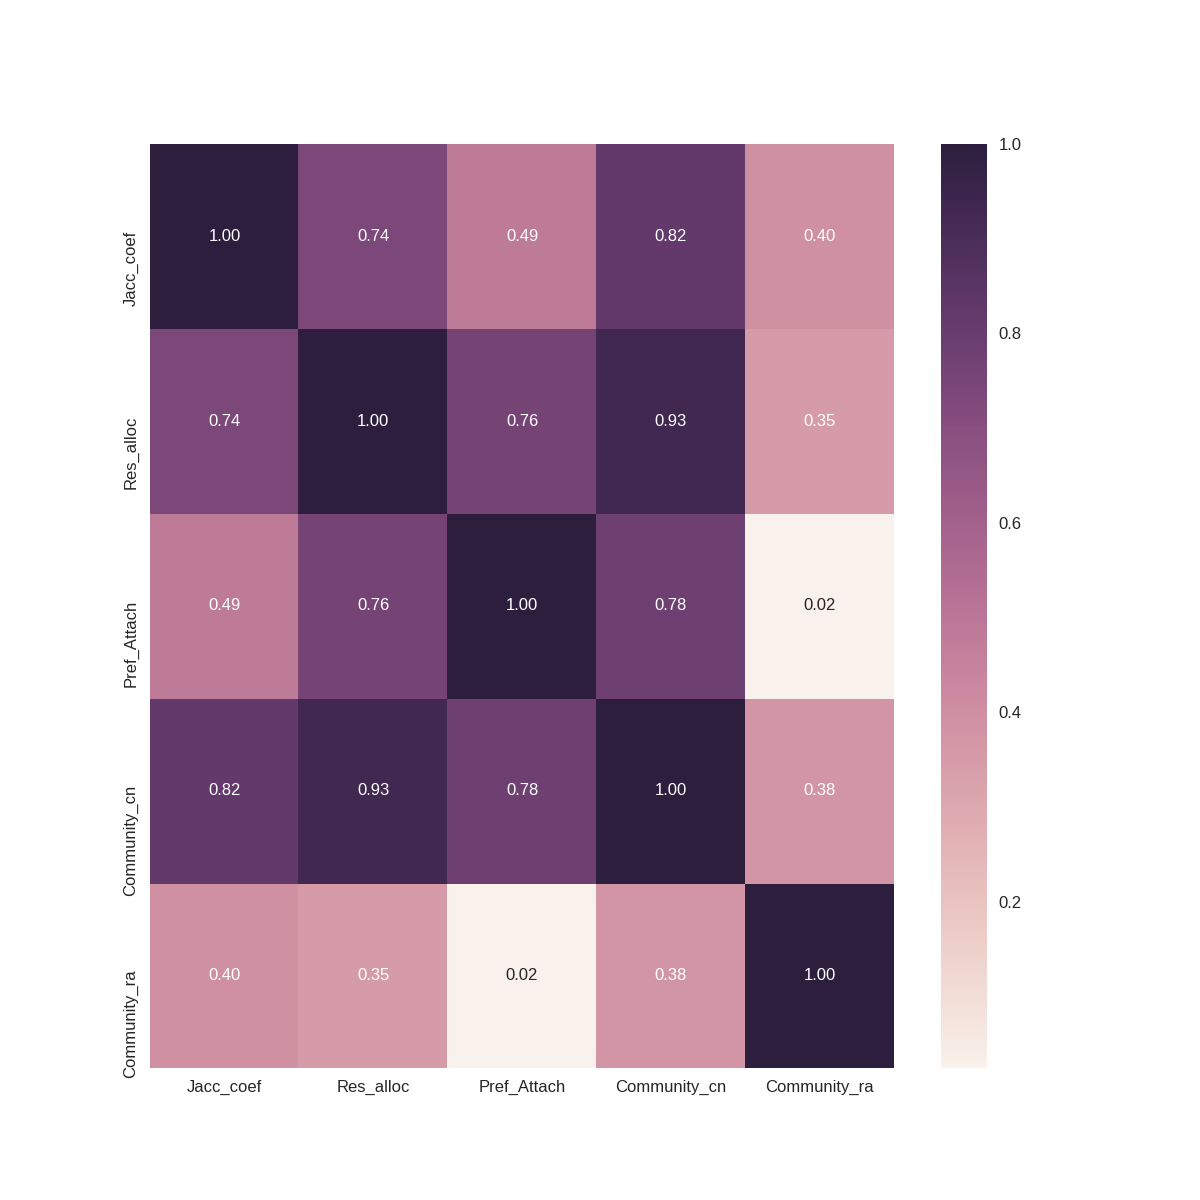

In [29]:
plt.figure(figsize=(10, 10))
sns.heatmap(X_train.corr(), annot=True, fmt='.2f')

In [30]:
X = df.drop(['Future Connection', 'Res_alloc', 'Jacc_coef', 'Pref_Attach'], axis=1)
y = df['Future Connection']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<IPython.core.display.Javascript object>


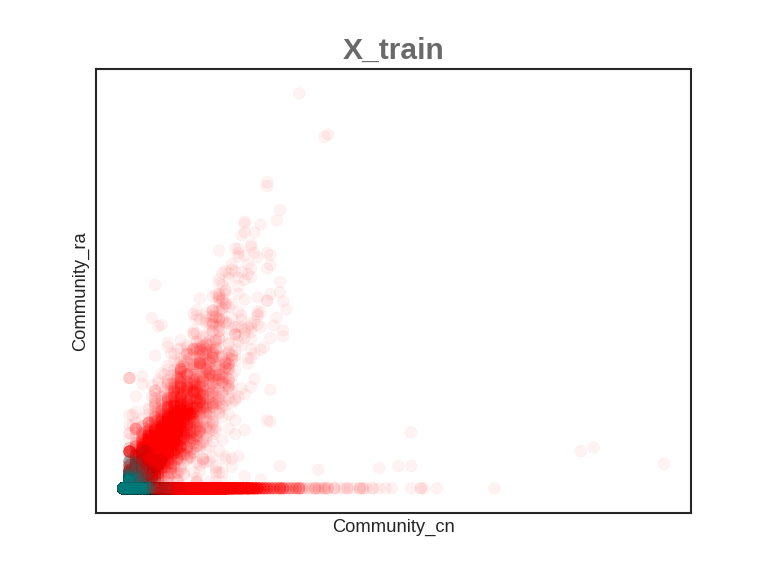

In [31]:
plt.figure()
plt.scatter(X_train['Community_cn'], X_train['Community_ra'], c=y_train.map({0: 'darkcyan', 1: 'red'}), alpha=0.05)

plt.title('X_train', fontsize=18, color='dimgrey', fontweight='bold')
plt.tick_params(labelbottom=False, labelleft=False)
plt.xlabel('Community_cn')
plt.ylabel('Community_ra');

We can linearly separate this data.

In [32]:
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
clf = LogisticRegression()

grid_values = {'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300]}

grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring='roc_auc', cv=5)

grid_clf_auc.fit(X_train_scaled, y_train)

y_decision_fn_scores_auc = grid_clf_auc.predict_proba(X_test_scaled)[:,1]
y_decision_fn_train_scores_auc = grid_clf_auc.predict_proba(X_train_scaled)[:,1]

print('Grid best parameter (max. auc): ', grid_clf_auc.best_params_)
print('Grid best score (auc): ', grid_clf_auc.best_score_)

print('Train set auc score', roc_auc_score(y_train, y_decision_fn_train_scores_auc))
print('Test set auc score', roc_auc_score(y_test, y_decision_fn_scores_auc))
print(pd.DataFrame(grid_clf_auc.cv_results_))

Grid best parameter (max. auc):  {'C': 300}
Grid best score (auc):  0.913993464924
Train set auc score 0.913999768119
Test set auc score 0.908707964805
   mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       0.402487         0.087634         0.913779          0.913782   0.001   
1       0.598445         0.090901         0.913729          0.913733    0.01   
2       0.627331         0.089266         0.913564          0.913568     0.1   
3       0.746460         0.087192         0.913756          0.913757       1   
4       0.806599         0.082706         0.913971          0.913975      10   
5       0.770388         0.122539         0.913984          0.913991      50   
6       0.780259         0.111148         0.913991          0.913995     100   
7       0.782194         0.092478         0.913993          0.913996     200   
8       0.803525         0.085198         0.913993          0.913995     300   

         params  rank_test_score  split0_test_s

In [33]:
LR = LogisticRegression(C = 0.01).fit(X_train_scaled, y_train)
print('Train set auc score: ', roc_auc_score(y_train, LR.decision_function(X_train_scaled)))
print('Test set auc score: ', roc_auc_score(y_test, LR.decision_function(X_test_scaled)))


Train set auc score:  0.913717159669
Test set auc score:  0.908444636303


In [73]:
clf = SVC(kernel='linear', C = 0.01).fit(X_train_scaled, y_train)
print('Train set auc score: ', roc_auc_score(y_train, clf.decision_function(X_train_scaled)))
print('Test set auc score: ', roc_auc_score(y_test, clf.decision_function(X_test_scaled)))


Train set auc score:  0.913976396942
Test set auc score:  0.908692953747


Those scores are very close. However, SVM takes much longer to find its maximum margin hyperplane. We'll take the Logistic Regression model to predict the future connections for edges not labeled that we put aside.

In [44]:
to_predict['link_prediction'] = pd.Series(LR.predict(to_predict[['Community_cn', 'Community_ra']]),
                                          index=to_predict.index )

In [45]:
to_predict.groupby('link_prediction')['Community_cn'].mean()

link_prediction
0.0    0.000000
1.0    4.410645
Name: Community_cn, dtype: float64

In [48]:
to_predict[to_predict['Community_cn'] > 0]['link_prediction'].mean()

1.0

Wow, it seems that our logistic regression model just yields a future connection value of 1 once an edge has a community common neighbors measure greater than 0. Our model assume for those data points that if two employees not connected yet have at least one connection in common in the same department, they will certainly be connected in the future.